# Mini Project 1

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

**Instructions** Use current stock data to create two potentially profitable investment portfolios. One that is higher risk and one that is lower risk.

-- You are to interpret and explain your interpretation of a high risk profile and low risk profile of a portfolio. You should provide some measurable quantitative data in your explanation.

# Selecting the Portfolios
We will choose as our high risk portfolio the 5 largest tech stocks by market capitalization. Our low risk portfolio will be the S&P 500. These selections are made to demonstrate the benefits of diversification.

In [1]:
import pandas as pd
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats

In [2]:
# building the high risk portfolio
tickers = ['AAPL', 'AMZN', 'GOOG', 'MSFT', 'NVDA']
tech = yf.download(tickers, start = '2013-01-01', end = '2025-01-01')['Close']

C:\Users\luvy\AppData\Local\Temp\ipykernel_13924\571376389.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tech = yf.download(tickers, start = '2013-01-01', end = '2025-01-01')['Close']
[*********************100%***********************]  5 of 5 completed


In [3]:
# S&P 500
sp500 = yf.download('^GSPC', start = '2013-01-01', end = '2025-01-01')['Close']

C:\Users\luvy\AppData\Local\Temp\ipykernel_13924\4010153981.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start = '2013-01-01', end = '2025-01-01')['Close']
[*********************100%***********************]  1 of 1 completed


# sample statistics

## high risk portfolio

In [4]:
tech_returns = tech.pct_change().dropna()
N_days, N_stocks = tech_returns.shape

trading_days = 250
tech_annual_mean_returns = tech_returns.mean() * trading_days
tech_annual_cov_matrix = tech_returns.cov() * trading_days

In [5]:
# returns of risky tech stocks
print(tech_annual_mean_returns)

Ticker
AAPL    0.263180
AMZN    0.286555
GOOG    0.232891
MSFT    0.277568
NVDA    0.608839
dtype: float64


In [6]:
# covariance of risky tech stocks
print(tech_annual_cov_matrix)

Ticker      AAPL      AMZN      GOOG      MSFT      NVDA
Ticker                                                  
AAPL    0.077482  0.043829  0.041833  0.044829  0.063378
AMZN    0.043829  0.103443  0.054613  0.050552  0.070660
GOOG    0.041833  0.054613  0.074815  0.048155  0.063117
MSFT    0.044829  0.050552  0.048155  0.068898  0.067971
NVDA    0.063378  0.070660  0.063117  0.067971  0.204368


In [7]:
# high correlation of risky tech stocks
print(tech_returns.corr())

Ticker      AAPL      AMZN      GOOG      MSFT      NVDA
Ticker                                                  
AAPL    1.000000  0.489568  0.549441  0.613557  0.503656
AMZN    0.489568  1.000000  0.620802  0.598811  0.485981
GOOG    0.549441  0.620802  1.000000  0.670723  0.510442
MSFT    0.613557  0.598811  0.670723  1.000000  0.572817
NVDA    0.503656  0.485981  0.510442  0.572817  1.000000


## low risk portfolio

In [8]:
sp500_returns = sp500.pct_change().dropna()
low_risk_annual_mean_returns = sp500_returns.mean() * trading_days
low_risk_annual_var = sp500_returns.var() * trading_days

In [9]:
# returns of low risk S&P
print(low_risk_annual_mean_returns)

Ticker
^GSPC    0.129481
dtype: float64


In [10]:
# variance of low risk S&P
print(low_risk_annual_var)

Ticker
^GSPC    0.028298
dtype: float64


In [11]:
# std of low risk S&P
SP_std = np.sqrt(low_risk_annual_var)
print(SP_std)

Ticker
^GSPC    0.168219
dtype: float64


## observations
While the S&P (low risk portfolio) has a lower return, it also has a lower variance. This begs the question, how low can we get the variance of the five risky stocks?

## minimal-variance portfolio
We minimize ${\bf w}^{\top} {\bf \Sigma} {\bf w}$ over all ${\bf w}$ subject to ${\bf w}{\bf 1} = {\bf 1}$. Using Lagrange multipliers, we can show that the solution is given by
$$
{\bf w} = \frac{\bf{\Sigma^{-1} 1}}{\bf{1^{\top}\Sigma^{-1} 1}}
$$

In [12]:
# some useful vectors to be used again later
ones = np.ones(N_stocks)
invC_1 = LA.solve(tech_annual_cov_matrix, ones)

# weights of minimal variance portfolio
min_var_weights = invC_1 / sum(invC_1)
print(pd.DataFrame({'ticker': tickers,
                    'weights': min_var_weights}))

  ticker   weights
0   AAPL  0.333348
1   AMZN  0.102056
2   GOOG  0.289432
3   MSFT  0.364816
4   NVDA -0.089651


In [13]:
# return of minimal variance portfolio
min_var_return = min_var_weights @ tech_annual_mean_returns
print(min_var_return)

0.23105921682309452


In [14]:
# minimal std
min_var_std = np.sqrt(min_var_weights @ tech_annual_cov_matrix @ min_var_weights)
print(min_var_std)

0.23039451543583564


## observations
The minimal variance portfolio has a mean annual return of 23\% with standard deviation 23\%. By constrast, the S\&P has a mean return of 13\% and a standard deviation of 16\%. What happens if we consider a mean-variance optimization?

## optimal mean-variance portfolio
We maxmize ${\bf \mu w} - \frac{\gamma}{2} {\bf w^{\top}\Sigma w}$ over all ${\bf w}$ subject to ${\bf w^{\top}1}$. The solution is given by
$$
{\bf w} = \frac{1}{\gamma}{\bf \Sigma}^{-1}({\bf \mu} - \lambda {\bf 1})
$$
where
$$
\lambda = \frac{{\bf 1^{\top}\Sigma^{-1}\mu} - \gamma}{{\bf 1^{\top}\Sigma^{-1}1}}
$$
For simplicity, we take $\gamma = 2$.

In [15]:
gam = 2
invC_mu = LA.solve(tech_annual_cov_matrix, tech_annual_mean_returns)
lam = (ones @ invC_mu - gam) / (ones @ invC_1)
mean_var_weights = (invC_mu - lam * invC_1) / gam

# weights
print(pd.DataFrame({'ticker': tickers,
                    'weights': mean_var_weights}))

  ticker   weights
0   AAPL -0.011471
1   AMZN  0.134098
2   GOOG -0.519906
3   MSFT  0.143115
4   NVDA  1.254164


In [16]:
# return of mean-variance portfolio
mean_var_return = mean_var_weights @ tech_annual_mean_returns
print(mean_var_return)

0.7176341644346808


In [17]:
# std of mean-variance portfolio
mean_var_std = np.sqrt(mean_var_weights @ tech_annual_cov_matrix @ mean_var_weights)
print(mean_var_std)

0.5443979303310279


## observations

The mean variance portfolio has a mean annual return of 72% with standard deviation 54%. By constrast, the S&P has a mean return of 13% and a standard deviation of 16%.

## efficient frontier

In [18]:
mSm = tech_annual_mean_returns @ invC_mu
mSe = tech_annual_mean_returns @ invC_1
eSe = ones @ invC_1

def weights(mu_star):
    A = mSm - mu_star * mSe
    B = eSe * mu_star - mSe
    C = eSe * mSm - mSe**2
    return (A * invC_1 + B * invC_mu) / C

In [19]:
mu = np.empty(100)
sig = np.empty(100)

for i,mu_star in enumerate(np.linspace(0,2,100)):
    w = weights(mu_star)
    mu[i] = w @ tech_annual_mean_returns
    sig[i] = np.sqrt(w @ tech_annual_cov_matrix @ w)

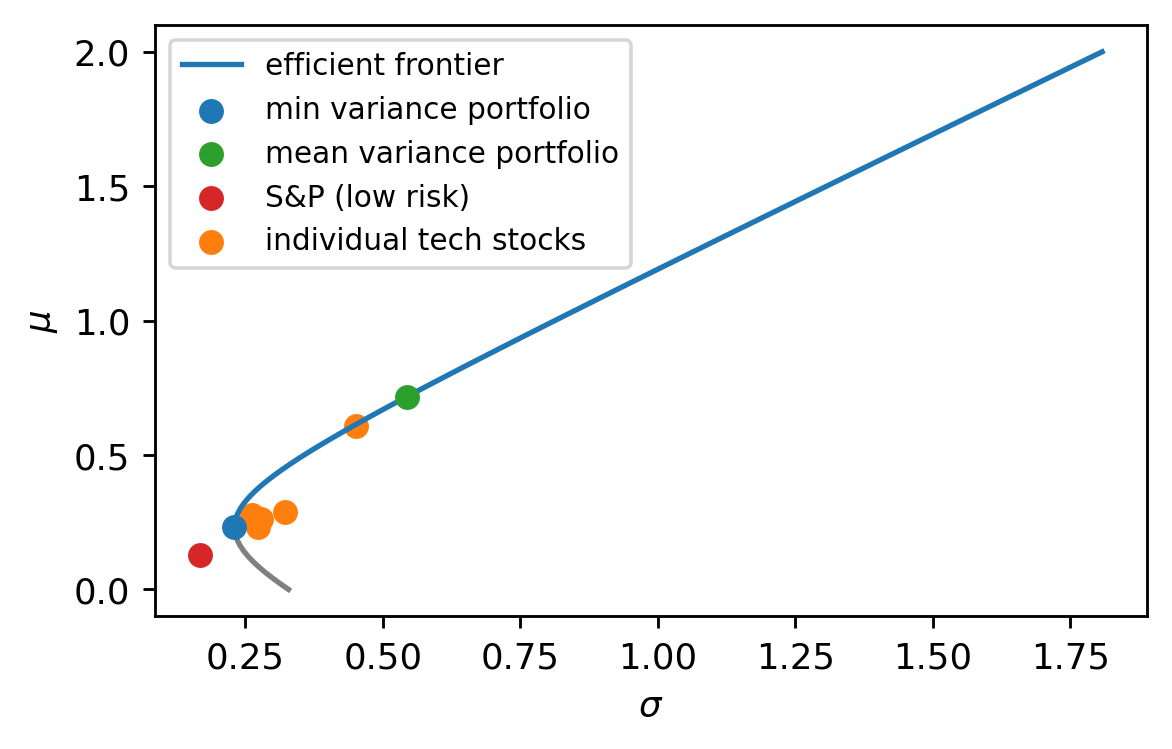

In [20]:
fig, ax = plt.subplots(figsize = (5,3), dpi = 256)

tech_annual_return_std = np.sqrt(np.diagonal(tech_annual_cov_matrix))

ax.plot(sig[mu > min_var_return], mu[mu > min_var_return],
        label = 'efficient frontier')
ax.scatter(min_var_std, min_var_return, c = 'C0', zorder = 3,
           label = 'min variance portfolio')
ax.scatter(mean_var_std, mean_var_return, c = 'C2', zorder = 3,
           label = 'mean variance portfolio')
ax.scatter(SP_std, low_risk_annual_mean_returns, c = 'C3', zorder = 3,
           label = 'S&P (low risk)')
ax.plot(sig[mu <= min_var_return], mu[mu <= min_var_return], c = 'gray')
ax.scatter(tech_annual_return_std, tech_annual_mean_returns,
           color = 'C1', label = 'individual tech stocks')
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$\mu$')
ax.legend(fontsize = 'small')
fig.savefig('fig1.jpeg', transparent = False, bbox_inches = 'tight');

## observations
The low risk portfolio consisting of the S&P does not lie to the upper left of the efficient frontier, as I had expected.